# Fitting Workshop

## Preparing dataset

In [1]:
from qcportal import PortalClient

# Connect to the QCArchive portal
client = PortalClient("https://api.qcarchive.molssi.org")  # TODO: Caching?

# Get all dataset names
datasets = client.list_datasets()

In [2]:
datasets = [
    (dataset["dataset_name"], dataset["dataset_type"])
    for dataset in datasets
    if "openff" in dataset["dataset_name"].lower()
    and (
        "lipid" in dataset["dataset_name"].lower()
        or "alkane" in dataset["dataset_name"].lower()
    )
]
datasets

[('OpenFF Alkane Torsion Drives v1.0', 'torsiondrive'),
 ('OpenFF Lipid Optimization Training Supplement v1.0', 'optimization'),
 ('OpenFF Lipid Optimization Benchmark Supplement v1.0', 'optimization'),
 ('OpenFF Lipid Torsion Drives v4.0', 'torsiondrive')]

In [3]:
from openff.qcsubmit.results import (
    OptimizationResultCollection,
    TorsionDriveResultCollection,
)
from openff.qcsubmit.results.filters import ElementFilter, SMARTSFilter

td_results = (
    TorsionDriveResultCollection.from_server(
        client=client,
        datasets=[
            "OpenFF Alkane Torsion Drives v1.0",
            "OpenFF Lipid Torsion Drives v4.0",
        ],
        spec_name="default",
    )
    .filter(ElementFilter(allowed_elements=["C", "H"]))
    .filter(SMARTSFilter(smarts_to_exclude=["[*]!-[*]"]))
)

In [4]:
f"{td_results.n_results=} {td_results.n_molecules=}"

'td_results.n_results=69 td_results.n_molecules=22'

In [5]:
opt_results = (
    OptimizationResultCollection.from_server(
        client=client,
        datasets=[
            "OpenFF Lipid Optimization Benchmark Supplement v1.0",
        ],
        spec_name="default",
    )
    .filter(ElementFilter(allowed_elements=["C", "H"]))
    .filter(SMARTSFilter(smarts_to_exclude=["[*]!-[*]"]))
)

In [6]:
f"{opt_results.n_results=} {opt_results.n_molecules=}"

'opt_results.n_results=110 opt_results.n_molecules=20'

In [7]:
# # TODO: Make this work on result collections and use it
# def train_test_split(
#     ds: datasets.Dataset,
#     frac_test: float,
# ) -> tuple[datasets.Dataset, datasets.Dataset]:
#     """Split ds into train and test subsets with diverse molecules in train

#     Returns
#     =======
#     (train_ds, test_ds)
#         train and test datasets
#     """
#     assert 0.0 < frac_test < 1.0

#     n_smiles = len(ds["smiles"])
#     n_test = round(frac_test * n_smiles)

#     test_indices = choose_diverse_molecules(n_test, ds["smiles"])
#     test_indices_set = test_indices
#     assert len(test_indices) == len(test_indices_set)
#     train_indices = [i for i in range(n_smiles) if i not in test_indices_set]

#     train_ds = ds.select(indices=train_indices)
#     test_ds = ds.select(indices=test_indices)
#     assert len(train_ds) + len(test_ds) == len(ds)
#     logger.info(
#         f"split dataset of {len(ds)} molecules into"
#         + f" training set of {len(train_ds)} and testing set of {len(test_ds)}",
#     )
#     return train_ds, test_ds


# def choose_diverse_molecules(
#     n: int,
#     smiles: Sequence[str],
#     seed: int | None = None,
# ) -> Sequence[int]:
#     """Choose n diverse molecules from a sequence of SMILES

#     Returns
#     =======
#     indices
#         The indices into the original SMILES sequence of the chosen molecules.
#     """
#     fingerprinter = rdFingerprintGenerator.GetMorganGenerator(radius=3)
#     fingerprints = [
#         fingerprinter.GetFingerprint(Chem.MolFromSmiles(s))
#         for s in tqdm(
#             smiles,
#             desc="Computing fingerprints",
#             ncols=80,
#         )
#     ]

#     picker = MaxMinPicker()
#     return picker.LazyBitVectorPick(
#         fingerprints,
#         len(fingerprints),
#         n,
#         seed=-1 if seed is None else seed,
#     )

AttributeError: 'list' object has no attribute 'Dataset'

In [8]:
from qcportal.client import SinglepointDriver

records, molecules = zip(
    *opt_results.to_basic_result_collection(
        [*SinglepointDriver],
    ).to_records(
        include=[
            "molecule",
            "identifiers",
            "properties",
        ]
    ),
    *(
        (min_opt_record.trajectory[-1], mol)
        for td_record, mol in td_results.to_records(
            include=[
                "molecule",
                "identifiers",
                "properties",
                "minimum_optimizations",
                "trajectory",
            ]
        )
        for min_opt_record in td_record.minimum_optimizations.values()
    ),
)

In [9]:
import descent.targets.energy
import numpy
import torch
import tqdm
from openff.toolkit.utils.exceptions import UndefinedStereochemistryError
from openff.units import Quantity, unit

data = {}
for record, molecule in tqdm.tqdm(list(zip(records, molecules))):
    smiles = (
        record.molecule.identifiers.canonical_isomeric_explicit_hydrogen_mapped_smiles
    )
    if smiles is None:
        smiles = molecule.to_smiles(mapped=True, isomeric=True, explicit_hydrogens=True)

    geometry = Quantity(record.molecule.geometry, "bohr")
    return_energy = (
        Quantity(
            record.properties["return_energy"],
            "hartree",
        )
        * unit.avogadro_constant
    )
    gradient = (
        Quantity(
            numpy.array(record.properties["scf total gradient"]).reshape((-1, 3)),
            "hartree/bohr",
        )
        * unit.avogadro_constant
    )

    entry = data.setdefault(
        smiles,
        descent.targets.energy.Entry(
            smiles=smiles,
            coords=[],
            energy=[],
            forces=[],
        ),
    )

    entry["coords"].append(geometry.m_as("angstrom"))
    entry["energy"].append(return_energy.m_as("kcal/mol"))
    entry["forces"].append(-gradient.m_as("kcal/mol/angstrom"))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1766/1766 [00:00<00:00, 3639.67it/s]


In [10]:
from openff.toolkit import Molecule

n_no_stereo = 0
for entry in data.values():
    n_confs = len(entry["energy"])
    n_atoms = Molecule.from_mapped_smiles(
        entry["smiles"], allow_undefined_stereo=True
    ).n_atoms
    entry["coords"] = numpy.asarray(entry["coords"]).reshape(n_confs, n_atoms, 3)
    entry["forces"] = numpy.asarray(entry["coords"]).reshape(n_confs, n_atoms, 3)

ds = descent.targets.energy.create_dataset(data.values())

In [11]:
# ??filtering??
# ??Check coverage??

## Parametrization

In [12]:
from openff.toolkit import ForceField, Molecule

initial_ff = ForceField("openff_unconstrained-2.3.0.offxml")

In [13]:
# TODO: Parallelize?

interchanges = [
    initial_ff.create_interchange(
        Molecule.from_mapped_smiles(smiles, allow_undefined_stereo=True).to_topology()
    )
    for smiles in tqdm.tqdm(ds["smiles"])
]

  2%|████▎                                                                                                                                                                                 | 1/42 [00:01<00:47,  1.17s/it][17:28:36] WARNING: Omitted undefined stereo

  5%|████████▋                                                                                                                                                                             | 2/42 [00:02<00:43,  1.10s/it][17:28:37] WARNING: Omitted undefined stereo

  7%|█████████████                                                                                                                                                                         | 3/42 [00:03<00:42,  1.09s/it][17:28:39] WARNING: Omitted undefined stereo

 10%|█████████████████▎                                                                                                                                                                    | 4/42 [00:04<00:45, 

In [14]:
import smee.converters

device = "cpu"

tensor_ff, tensor_tops = smee.converters.convert_interchange(interchanges)

assert len(tensor_tops) == len(interchanges) == len(ds)

tensor_tops_by_smiles = {
    smiles: ttop.to(device) for smiles, ttop in zip(ds["smiles"], tensor_tops)
}
tensor_ff = tensor_ff.to(device)

## Fitting

In [15]:
import descent.train

parameters = {
    "Bonds": descent.train.ParameterConfig(
        cols=["k", "length"],
        scales={"k": 1.0e-2, "length": 1.0},
        limits={"k": [0.0, None], "length": [0.0, None]},
    ),
    "Angles": descent.train.ParameterConfig(
        cols=["k", "angle"],
        scales={"k": 1.0e-2, "angle": 1.0e-2},
        limits={"k": [0.0, None], "angle": [0.0, 3.141592653589793]},
    ),
    "ProperTorsions": descent.train.ParameterConfig(
        cols=["k"],
        scales={"k": 1.0e1},
        limits={"k": [0.0, None]},
    ),
}
attributes: dict[str, descent.train.AttributeConfig] = {}

In [16]:
trainable = descent.train.Trainable(
    force_field=tensor_ff, parameters=parameters, attributes=attributes
)

In [17]:
import tensorboardX
import torch
from tqdm.notebook import tqdm

energy_weight = 1.0
force_weight = 1.0
n_epochs = 10
learning_rate = 1.0 / 15000
batch_size = len(ds)
directory = "tensorboard_logs"
train_data = ds

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    collate_fn=lambda samples: samples,
    pin_memory=True,
)
trainable_parameters = trainable.to_values().to(device)

print("Start training...")
with tensorboardX.SummaryWriter(str(directory)) as writer:
    optimizer = torch.optim.Adam(
        [trainable_parameters],
        lr=learning_rate,
        amsgrad=True,
    )

    epoch_tqdm = tqdm(range(n_epochs), desc="epochs", dynamic_ncols=True)
    for i in epoch_tqdm:
        ff = trainable.to_force_field(trainable_parameters)
        epoch_loss = torch.zeros(size=(1,), device=device)
        energy_loss = torch.zeros(size=(1,), device=device)
        force_loss = torch.zeros(size=(1,), device=device)
        grad = None

        batch_tqdm = tqdm(
            leave=False,
            desc="computing loss",
            total=len(train_data),
            unit="tops",
            dynamic_ncols=True,
        )
        for cpu_batch in train_dataloader:
            # Copy the batch to device
            batch = [
                {k: v if k == "smiles" else v.to(device) for k, v in sample.items()}
                for sample in cpu_batch
            ]
            true_batch_size = len(batch)
            # Compute forces and energies
            e_ref, e_pred, f_ref, f_pred = descent.targets.energy.predict(
                batch,  # type: ignore
                ff,
                tensor_tops_by_smiles,
                "mean",
            )
            # Compute L2 loss
            batch_loss_energy = ((e_pred - e_ref) ** 2).sum() / true_batch_size
            batch_loss_force = ((f_pred - f_ref) ** 2).sum() / true_batch_size

            # Equal sum of L2 loss on energies and forces
            batch_loss = batch_loss_energy + batch_loss_force

            # Compute the gradient of batch_loss wrt trainable_parameters
            (batch_grad,) = torch.autograd.grad(
                batch_loss,
                trainable_parameters,
                create_graph=True,
            )
            # Add the batch gradient to the cumulative epoch gradient
            batch_grad = batch_grad.detach()
            if grad is None:
                grad = batch_grad
            else:
                grad += batch_grad

            # keep cumulative epoch losses to report MSE at the end
            epoch_loss += batch_loss.detach()
            energy_loss += batch_loss_energy.detach()
            force_loss += batch_loss_force.detach()

            # Update the progress bar
            batch_tqdm.update(true_batch_size)
        batch_tqdm.close()

        # Write results to logs
        epoch_tqdm.set_description(
            f"loss: {epoch_loss.detach().item()}, epochs",
        )

        writer.add_scalar("loss", epoch_loss.detach().item(), i)
        writer.add_scalar("loss_energy", energy_loss.detach().item(), i)
        writer.add_scalar("loss_forces", force_loss.detach().item(), i)

        writer.add_scalar("rmse_energy", energy_loss.detach().sqrt().item(), i)
        writer.add_scalar("rmse_forces", force_loss.detach().sqrt().item(), i)
        writer.flush()

        # Perform the optimization step
        trainable_parameters.grad = grad
        optimizer.step()
        optimizer.zero_grad()

Start training...


epochs:   0%|                                                                                                 …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

computing loss:   0%|                                                                                         …

In [18]:
%load_ext tensorboard
%tensorboard --logdir $directory

Reusing TensorBoard on port 6006 (pid 43494), started 3:40:08 ago. (Use '!kill 43494' to kill it.)

In [19]:
optimized_tensor_ff = trainable.to_force_field(trainable_parameters)

In [20]:
import warnings
from collections.abc import Collection

from openff.toolkit.typing.engines.smirnoff.parameters import ParameterHandler

HANDLERS_WITHOUT_XML_PARAMETERS = {
    "NAGLChargesHandler",
    "ToolkitAM1BCCHandler",
}


def update_parameters(
    handler: ParameterHandler,
    potential: smee.TensorPotential,
    config: descent.train.ParameterConfig | None,
):

    for key, values in zip(
        potential.parameter_keys,
        potential.parameters,
        strict=True,
    ):
        if key.associated_handler in HANDLERS_WITHOUT_XML_PARAMETERS:
            continue
        parameter = handler[key.id]
        for name, unit, value in zip(
            potential.parameter_cols,
            potential.parameter_units,
            values,
            strict=True,
        ):
            if config is not None and name not in config.cols:
                continue
            name = name if key.mult is None else f"{name}{key.mult+1}"
            try:
                setattr(parameter, name, value * unit)
            except Exception:
                warnings.warn(
                    f"    COULD NOT UPDATE {key.id=} {name=} {unit=} {value=} {key.mult=}"
                )


def update_attributes(
    handler: ParameterHandler,
    potential: smee.TensorPotential,
    config: descent.train.AttributeConfig | None,
):
    for name, value, unit in zip(
        [] if potential.attribute_cols is None else potential.attribute_cols,
        [] if potential.attributes is None else potential.attributes,
        [] if potential.attribute_units is None else potential.attribute_units,
        strict=True,
    ):
        if config is not None and name not in config.cols:
            continue
        setattr(handler, name, value * unit)


def write_smirnoff(
    initial_ff: ForceField,
    optimized_tensor_ff: smee.TensorForceField,
    parameters: None | dict[str, descent.train.ParameterConfig] = None,
    attributes: None | dict[str, descent.train.AttributeConfig] = None,
):

    optimized_smirnoff_ff = ForceField(initial_ff.to_string())
    for potential in optimized_tensor_ff.potentials:
        print(potential.type)
        handler = optimized_smirnoff_ff[potential.type]
        if parameters is None or potential.type in parameters:
            print("  updating parameters")
            update_parameters(
                handler,
                potential,
                None if parameters is None else parameters[potential.type],
            )
        if attributes is None or potential.type in attributes:
            print("  updating attributes")
            update_attributes(
                handler,
                potential,
                None if attributes is None else attributes[potential.type],
            )
    return optimized_smirnoff_ff


optimized_smirnoff_ff = write_smirnoff(
    initial_ff,
    optimized_tensor_ff,
    parameters,
    attributes,
)

Angles
  updating parameters
Bonds
  updating parameters
Electrostatics
ProperTorsions
  updating parameters
vdW


In [21]:
from pathlib import Path

Path("optimized.offxml").write_text(optimized_smirnoff_ff.to_string())

105264

In [22]:
for a, b in zip(
    optimized_smirnoff_ff.to_string().splitlines(), initial_ff.to_string().splitlines()
):
    if a != b:
        print(f"INI: {b}", "\n", f"OPT: {a}", sep="")

INI:         <Bond smirks="[#6X4:1]-[#6X4:2]" id="b1" length="1.525970013793 * angstrom ** 1" k="457.9258198725 * angstrom ** -2 * kilocalorie_per_mole ** 1"></Bond>
OPT:         <Bond smirks="[#6X4:1]-[#6X4:2]" id="b1" length="1.5254694629176924 * angstrom ** 1" k="457.94961176099207 * angstrom ** -2 * kilocalorie ** 1 * mole ** -1"></Bond>
INI:         <Bond smirks="[#6X4:1]-[#1:2]" id="b84" length="1.092445809108 * angstrom ** 1" k="680.7664447835 * angstrom ** -2 * kilocalorie_per_mole ** 1"></Bond>
OPT:         <Bond smirks="[#6X4:1]-[#1:2]" id="b84" length="1.0930794177823842 * angstrom ** 1" k="680.7022457320604 * angstrom ** -2 * kilocalorie ** 1 * mole ** -1"></Bond>
INI:         <Angle smirks="[*:1]~[#6X4:2]-[*:3]" angle="109.6505556522 * degree ** 1" k="99.69215181429 * kilocalorie_per_mole ** 1 * radian ** -2" id="a1"></Angle>
OPT:         <Angle smirks="[*:1]~[#6X4:2]-[*:3]" angle="1.9386204819240342 * radian ** 1" k="99.62817952464762 * kilocalorie ** 1 * mole ** -1 * rad

## Benchmarks

- Visual inspection of structures
- YAMMBS? Not designed to be stable, user-facing software (present as "our internal benchmark software")

In [23]:
import pathlib
from multiprocessing import freeze_support

import numpy
from matplotlib import pyplot
from yammbs import MoleculeStore
from yammbs.inputs import QCArchiveDataset
from yammbs.outputs import MetricCollection


def plot(store: MoleculeStore, force_fields: list[str]):
    """Plot metrics of a list of force fields."""
    metrics = store.get_metrics()

    x_ranges = {
        "dde": (-16.0, 16.0),
        "rmsd": (-0.3, 3.3),
        "tfd": (-0.05, 0.55),
    }

    # metrics are stored with force field at the top of the hierarchy,
    # restructure it so that the type of metric is at the top

    # these each keep the qcarchive_id in case it's useful, though they're not
    # used in this script
    ddes: dict[str, dict[int, float]] = {
        force_field: {key: val.dde for key, val in metrics.metrics[force_field].items()}
        for force_field in metrics.metrics.keys()
    }

    rmsds = {
        force_field: {
            key: val.rmsd for key, val in metrics.metrics[force_field].items()
        }
        for force_field in metrics.metrics.keys()
    }

    tfds = {
        force_field: {key: val.tfd for key, val in metrics.metrics[force_field].items()}
        for force_field in metrics.metrics.keys()
    }

    data = {
        "dde": ddes,
        "rmsd": rmsds,
        "tfd": tfds,
    }
    for key in ["dde", "rmsd", "tfd"]:
        figure, axis = pyplot.subplots()

        for force_field in force_fields:
            if key == "dde":
                _data = numpy.array(
                    [*data[key][force_field].values()],
                    dtype=float,
                )

                counts, bins = numpy.histogram(
                    _data[numpy.isfinite(_data)],
                    bins=numpy.linspace(-15, 15, 31),
                )

                axis.stairs(counts, bins, label=force_field)

                axis.set_ylabel("Count")

            else:
                sorted_data = numpy.sort([*data[key][force_field].values()])

                axis.plot(
                    sorted_data,
                    numpy.arange(1, len(sorted_data) + 1) / len(sorted_data),
                    "-",
                    label=force_field,
                )

                axis.set_xlabel(key)
                axis.set_ylabel("CDF")

                axis.set_xlim(x_ranges[key])
                axis.set_ylim((-0.05, 1.05))

        axis.legend(loc=0)

        figure.savefig(f"{key}.png", dpi=300)

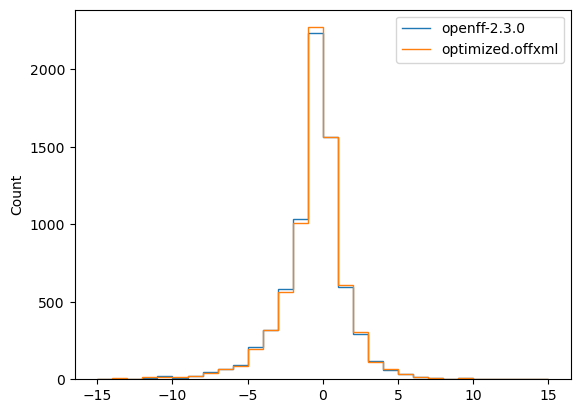

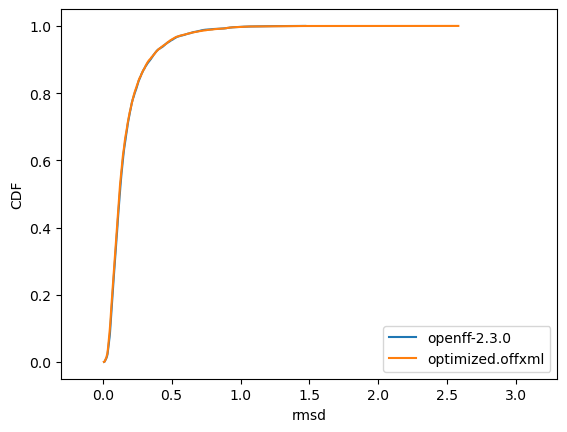

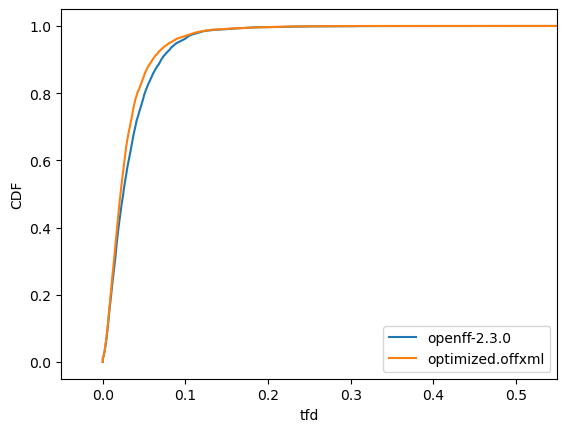

In [26]:
from yammbs.inputs import QCArchiveDataset

force_fields = [
    "openff-2.3.0",
    "optimized.offxml",
]

# TODO: Make sure this uses the optimization in https://github.com/openforcefield/yammbs/pull/233

dataset = QCArchiveDataset.from_qcsubmit_collection(
    OptimizationResultCollection.from_server(
        client=client,
        datasets=[
            "OpenFF Lipid Optimization Benchmark Supplement v1.0",
        ],
        spec_name="default",
    )
)

dataset_path = Path("lipids_benchmark.sqlite")
if dataset_path.exists():
    store = MoleculeStore(dataset_path)
else:
    store = MoleculeStore.from_qm_dataset(
        dataset,
        database_name=str(dataset_path),
    )

for force_field in force_fields:
    # This is called within each analysis method, but short-circuiting within them. It's convenient to call it here
    # with the freeze_support setup so that later analysis methods can trust that the MM conformers are there
    store.optimize_mm(force_field=force_field, n_processes=10)

plot(store, force_fields)

## Benchmark Torsions

In [46]:
import pathlib
from multiprocessing import freeze_support

import numpy as np
from matplotlib import pyplot
from openff.toolkit import Molecule
from rdkit.Chem import AllChem, Draw
from yammbs.torsion import TorsionStore
from yammbs.torsion.inputs import QCArchiveTorsionDataset
from yammbs.torsion.outputs import MetricCollection
from yammbs.torsion import TorsionStore


def get_torsion_image(torsion_id: int, store: TorsionStore) -> pyplot.Figure:
    """Plot the torsion image for a given molecule ID."""
    smiles = store.get_smiles_by_torsion_id(torsion_id)
    dihedral_indices = store.get_dihedral_indices_by_torsion_id(torsion_id)

    # Use the mapped SMILES to get the molecule
    mol = Molecule.from_mapped_smiles(smiles, allow_undefined_stereo=True)
    if mol is None:
        raise ValueError(f"Could not convert SMILES to molecule: {smiles}")

    rdmol = mol.to_rdkit()

    # Draw in 2D - compute 2D coordinates
    AllChem.Compute2DCoords(rdmol)
    # Highlight the dihedral
    atom_indices = [
        dihedral_indices[0],
        dihedral_indices[1],
        dihedral_indices[2],
        dihedral_indices[3],
    ]
    bond_indices = [
        rdmol.GetBondBetweenAtoms(atom_indices[0], atom_indices[1]).GetIdx(),
        rdmol.GetBondBetweenAtoms(atom_indices[1], atom_indices[2]).GetIdx(),
        rdmol.GetBondBetweenAtoms(atom_indices[2], atom_indices[3]).GetIdx(),
    ]
    img = Draw.MolToImage(
        rdmol,
        size=(300, 300),
        kekulize=True,
        wedgeBonds=True,
        highlightAtoms=atom_indices,
        highlightBonds=bond_indices,
    )
    # img = Draw.MolToImage(rdmol, size=(300, 300), kekulize=True, wedgeBonds=True)

    # Return the image so that it can be added to a matplotlib figure
    return img


def plot_torsions(plot_dir: str, force_fields: list[str], store: TorsionStore) -> None:
    """Plot the torsional energies for each molecule in the dataset."""
    n_rows = 8
    n_cols = 5

    # Adjust number of rows and columns down if we have fewer than 40 molecules
    n_molecules = len(store.get_torsion_ids())
    if n_molecules * 2 < n_rows * n_cols:
        n_rows = n_molecules // n_cols
        if n_molecules % n_cols != 0:
            n_rows += 1
    n_rows *= 2  # Two rows for each molecule

    n_torsions = n_rows * n_cols / 2  # Half the axes are for images

    fig, axes = pyplot.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

    for i, torsion_id in enumerate(store.get_torsion_ids()):
        # Draw the molecule on the upper axis and the torsion plot on the lower axis
        if i >= n_torsions:
            break

        # Put the image on upper rows and the torsion plots underneath
        col = i % n_cols
        row = i // n_cols
        image_axis = axes[row * 2, col]
        torsion_axis = axes[row * 2 + 1, col]

        # Draw the molecule
        image_axis.imshow(get_torsion_image(torsion_id, store))
        image_axis.axis("off")

        # Plot the torsion data
        torsion_axis.set_title(f"ID: {torsion_id}")
        _qm = store.get_qm_energies_by_torsion_id(torsion_id)

        _qm = dict(sorted(_qm.items()))

        qm_minimum_index = min(_qm, key=_qm.get)

        # Make a new dict to avoid in-place modification while iterating
        qm = {key: _qm[key] - _qm[qm_minimum_index] for key in _qm}

        # Assume a default grid spacing of 15 degrees (BespokeFit default)
        angles = np.arange(-165, 195, 15)
        assert len(angles) == len(qm), "QM data and angles should match in length"

        torsion_axis.plot(
            angles,
            qm.values(),
            "k.-",
            label="QM",
        )

        for force_field in force_fields:
            mm = dict(
                sorted(
                    store.get_mm_energies_by_torsion_id(
                        torsion_id, force_field=force_field
                    ).items()
                )
            )
            if len(mm) == 0:
                continue

            torsion_axis.plot(
                angles,
                [val - mm[qm_minimum_index] for val in mm.values()],
                "o--",
                label=force_field,
            )

        # Only add the axis if this is the last in the row - and add it off to the right
        if col == n_cols - 1:
            torsion_axis.legend(loc=0, bbox_to_anchor=(1.05, 1), borderaxespad=0)

        # Label the axes
        torsion_axis.set_ylabel(r"Energy / kcal mol$^{-1}$")
        torsion_axis.set_xlabel("Torsion angle / degrees")

    # Hide any unused axes
    for i in range(n_molecules, n_rows * n_cols):
        if i >= n_torsions:
            break
        col = i % n_cols
        row = i // n_cols
        axes[row * 2, col].axis("off")
        axes[row * 2 + 1, col].axis("off")

    fig.tight_layout()
    fig.savefig(f"{plot_dir}/torsions.png", dpi=300, bbox_inches="tight")


def plot_cdfs(force_fields: list[str], metrics: MetricCollection, plot_dir: str):
    """Plot the cumulative distribution functions for the RMSD, RMSE, and Jensen-Shannon distance."""
    x_ranges = {"rmsd": (0, 0.14), "rmse": (-0.3, 5), "js_distance": (None, None)}

    units = {
        "rmsd": r"$\mathrm{\AA}$",
        "rmse": r"kcal mol$^{-1}$",
        "js_distance": "",
    }

    rmsds = {
        force_field: {
            key: val.rmsd for key, val in metrics.metrics[force_field].items()
        }
        for force_field in metrics.metrics.keys()
    }

    rmses = {
        force_field: {
            key: val.rmse for key, val in metrics.metrics[force_field].items()
        }
        for force_field in metrics.metrics.keys()
    }

    js_dists = {
        force_field: {
            key: val.js_distance[0] for key, val in metrics.metrics[force_field].items()
        }
        for force_field in metrics.metrics.keys()
    }

    js_div_temp = list(list(metrics.metrics.values())[0].values())[0].js_distance[1]

    data = {
        "rmsd": rmsds,
        "rmse": rmses,
        "js_distance": js_dists,
    }
    for key in ["rmsd", "rmse", "js_distance"]:
        figure, axis = pyplot.subplots()

        for force_field in force_fields:
            if key == "dde":
                _data = np.array(
                    [*data[key][force_field].values()],
                    dtype=float,
                )

                counts, bins = np.histogram(
                    _data[np.isfinite(_data)],
                    bins=np.linspace(-15, 15, 31),
                )

                axis.stairs(counts, bins, label=force_field)

                axis.set_ylabel("Count")

            else:
                sorted_data = np.sort([*data[key][force_field].values()])

                axis.plot(
                    sorted_data,
                    np.arange(1, len(sorted_data) + 1) / len(sorted_data),
                    "-",
                    label=force_field,
                )

                x_label = (
                    key.upper() + " / " + units[key]
                    if key != "js_distance"
                    else f"Jensen-Shannon Distance at {js_div_temp} K"
                )
                axis.set_xlabel(x_label)
                axis.set_ylabel("CDF")

                axis.set_xlim(x_ranges[key])
                axis.set_ylim((-0.05, 1.05))

        axis.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

        figure.savefig(f"{plot_dir}/{key}.png", dpi=300, bbox_inches="tight")


def get_rms(array: np.ndarray) -> float:
    """Calculate the root mean square of an array."""
    return np.sqrt(np.mean(array**2))


def plot_rms_stats(
    force_fields: list[str],
    metrics: MetricCollection,
    plot_dir: str,
) -> None:
    """Plot the RMS values for the RMSD and RMSE."""

    units = {
        "rmsd": r"$\mathrm{\AA}$",
        "rmse": r"kcal mol$^{-1}$",
    }

    rms_rmses = {
        force_field: get_rms(
            np.array([val.rmse for val in metrics.metrics[force_field].values()])
        )
        for force_field in force_fields
    }

    rms_rmsds = {
        force_field: get_rms(
            np.array([val.rmsd for val in metrics.metrics[force_field].values()])
        )
        for force_field in force_fields
    }

    # Plot RMS values
    for key, data in zip(["rmsd", "rmse"], [rms_rmsds, rms_rmses]):
        figure, axis = pyplot.subplots()

        # Use different colors for each bar - the same as for the CDFs
        axis.bar(data.keys(), data.values(), color=pyplot.cm.tab10.colors)
        axis.set_ylabel(key.upper() + " / " + units[key])

        # Set x-ticks to be vertical
        pyplot.xticks(rotation=90)

        # Save the figure
        figure.tight_layout()
        figure.savefig(f"{plot_dir}/{key}_rms.png", dpi=300, bbox_inches="tight")


def plot_rms_js_distance(
    force_fields: list[str],
    metrics: MetricCollection,
    plot_dir: str,
) -> None:
    """Plot the RMS JS distance for each force field."""

    rms_js_distance = {
        force_field: get_rms(
            np.array(
                [val.js_distance[0] for val in metrics.metrics[force_field].values()]
            )
        )
        for force_field in force_fields
    }

    js_div_temp = list(list(metrics.metrics.values())[0].values())[0].js_distance[1]

    # Plot mean JS distance
    figure, axis = pyplot.subplots()

    axis.bar(
        rms_js_distance.keys(), rms_js_distance.values(), color=pyplot.cm.tab10.colors
    )
    axis.set_ylabel(f"Mean Jensen-Shannon Distance at {js_div_temp} K")

    # Set x-ticks to be vertical
    pyplot.xticks(rotation=90)

    # Save the figure
    figure.tight_layout()
    figure.savefig(f"{plot_dir}/mean_js_distance.png", dpi=300, bbox_inches="tight")


def plot_mean_error_distribution(
    force_fields: list[str],
    metrics: MetricCollection,
    plot_dir: str,
) -> None:
    """Plot the distribution of mean errors for each force field."""

    units = {
        "mean_error": r"kcal mol$^{-1}$",
    }

    mean_errors = {
        force_field: np.array(
            [val.mean_error for val in metrics.metrics[force_field].values()]
        )
        for force_field in force_fields
    }
    # Plot mean error distribution using kernel density estimation
    figure, axis = pyplot.subplots(figsize=(10, 4))
    import seaborn as sns

    for force_field in mean_errors.keys():
        sns.kdeplot(
            data=mean_errors[force_field],
            label=force_field,
            ax=axis,
        )
    axis.set_xlabel("Mean Error / " + units["mean_error"])
    axis.set_ylabel("Density")
    axis.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Save the figure
    figure.tight_layout()
    figure.savefig(
        f"{plot_dir}/mean_error_distribution.png", dpi=300, bbox_inches="tight"
    )

In [31]:
from yammbs.inputs import QCArchiveDataset

force_fields = [
    "openff-2.3.0",
    "optimized.offxml",
]

benchmark_td_results = TorsionDriveResultCollection.from_server(
    client=client,
    datasets=[
        "OpenFF Alkane Torsion Drives v1.0",
    ],
    spec_name="default",
)



In [38]:
from yammbs.torsion.inputs import QCArchiveTorsionDataset, QCArchiveTorsionProfile
import qcelemental

hartree2kcalmol = qcelemental.constants.hartree2kcalmol
bohr2angstroms = qcelemental.constants.bohr2angstroms

# TODO: Replace this function with a call to QCArchiveTorsionDataset.from_qcsubmit_collection after https://github.com/openforcefield/yammbs/pull/233 is merged
def qca_torsion_dataset_from_qcsubmit_collection(
    collection: TorsionDriveResultCollection,
) -> QCArchiveTorsionDataset:
    """Create a QCArchiveTorsionDataset from a TorsionDriveResultCollection."""
    
    return QCArchiveTorsionDataset(
        qm_torsions=[
            QCArchiveTorsionProfile(
                id=record.id,
                mapped_smiles=molecule.to_smiles(
                    mapped=True,
                    isomeric=True,
                    explicit_hydrogens=True,
                ),
                dihedral_indices=record.specification.keywords.dihedrals[
                    0
                ],  # might be 2-D in the future, 1-D for now
                qcarchive_id=record.id,
                coordinates={
                    grid_id[0]: optimization.final_molecule.geometry * bohr2angstroms
                    for grid_id, optimization in record.minimum_optimizations.items()
                },
                energies={
                    grid_id[0]: optimization.energies[-1] * hartree2kcalmol
                    for grid_id, optimization in record.minimum_optimizations.items()
                },
            )
            for record, molecule in collection.to_records(include=["id", "minimum_optimizations", "final_molecule", "specification", "energies"])
        ],
    )

dataset = qca_torsion_dataset_from_qcsubmit_collection(benchmark_td_results)


In [49]:
dataset_path = Path("lipids_benchmark_torsions.sqlite")
if dataset_path.exists():
    store = TorsionStore(dataset_path)
else:
    store = TorsionStore.from_torsion_dataset(
        dataset,
        database_name=str(dataset_path),
    )

In [ ]:
for force_field in force_fields:
    store.optimize_mm(force_field=force_field, n_processes=24)

Building and minimizing systems with openff-2.3.0: 0it [10:17:47, ?it/s]Process ForkPoolWorker-179:
Process ForkPoolWorker-181:
Process ForkPoolWorker-180:
Process ForkPoolWorker-174:
Process ForkPoolWorker-183:
Process ForkPoolWorker-178:
Process ForkPoolWorker-173:
Process ForkPoolWorker-171:
Process ForkPoolWorker-172:
Process ForkPoolWorker-176:
Process ForkPoolWorker-177:
Process ForkPoolWorker-170:
Process ForkPoolWorker-164:
Process ForkPoolWorker-175:
Process ForkPoolWorker-165:
Process ForkPoolWorker-162:
Process ForkPoolWorker-163:
Process ForkPoolWorker-182:
Process ForkPoolWorker-169:
Process ForkPoolWorker-168:
Process ForkPoolWorker-160:
Process ForkPoolWorker-167:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last

In [ ]:
plot_dir = "torsions"
plot_torsions(plot_dir, force_fields, store)

In [ ]:
metrics = store.get_metrics()

In [ ]:
# Plot!
plot_cdfs(force_fields, metrics, plot_dir)
plot_rms_stats(force_fields, metrics, plot_dir)
plot_mean_error_distribution(force_fields, metrics, plot_dir)
plot_rms_js_distance(force_fields, metrics, plot_dir)